In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import torch
from src.model import Model
from src.utility import checkpoint
from argparse import Namespace
from pathlib import Path 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('inline')

import sys 
sys.path.append('src')

## Args

In [3]:
args = Namespace()
args.scale = 2
args.model = 'unet'
args.self_ensemble = False
args.chop = False
args.precision = 'single'
args.save_models = True
args.pre_train = ''
args.resume = 0
args.feature_scale = 1
args.meannormal = False
args.load = ''
args.save = 'alpha6'
args.reset = False
args.test_only = True
args.data_test = 'xxxx'
args.own = True

### TODO:
args.cpu = False
args.n_GPUs = 1
args.pre_train = 'experiment/alpha6/model/model_best.pt'

## Load model

In [4]:
ckpt = checkpoint(args)
model = Model(args, ckpt)

Making model...
Load the model from experiment/alpha6/model/model_best.pt


/home/jtli/code/mycode/srunet/src/model/__init__.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_from = torch.load(pre_train, **kwargs)


In [5]:
def infer(model: torch.nn.Module, data):
    model = model.eval()
    with torch.no_grad():
        sr = model(data)
    sr = sr[0, 0].detach().cpu().numpy()
    return sr

## Load Data

In [8]:
# data.shape = (nw, nt)
data = np.fromfile('xxxx/lulia_592x400.dat', np.float32).reshape(592, 400)

# record mean and std
mean_v = data.mean()
std_v = data.std()

data = (data - mean_v) / std_v
data = data.T

# data.shape = (nt, nw)

In [9]:
inp = torch.from_numpy(data[np.newaxis, np.newaxis])

# clip
inp = torch.clamp(inp, -3.2, 3.2)

# record min and max
min_v = inp.min().item()
max_v = inp.max().item()

inp = (inp - min_v) / (max_v - min_v)
inp = inp.to('cuda')

## Run

In [10]:
out = infer(model, inp)

In [18]:
out = out * (max_v - min_v) + min_v

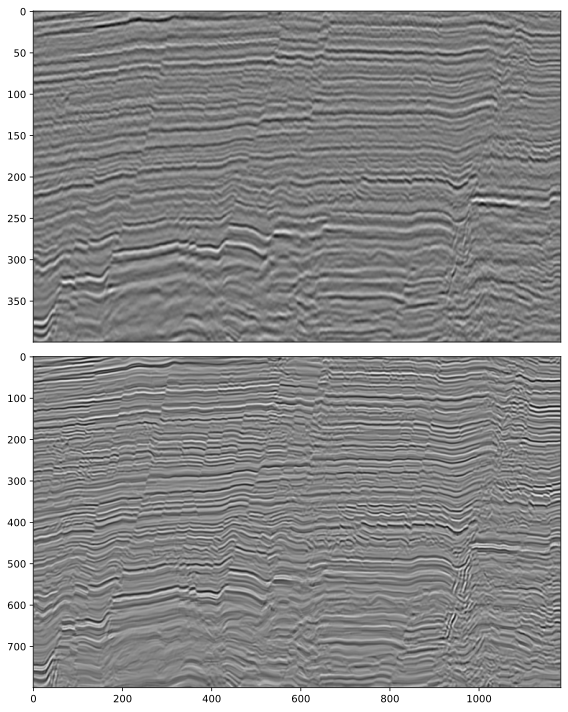

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].imshow(data, cmap='gray', aspect='auto')
ax[1].imshow(out, cmap='gray', aspect='auto')
ax[0].set_xticks([])
plt.tight_layout()
plt.show()